In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import warnings

warnings.filterwarnings("ignore")

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

AUTOTUNE = tf.data.AUTOTUNE

## Lectura de datos

In [3]:
data_dir = "../data/2_processed"   

paths = []
labels = []

for label_name in sorted(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, label_name)
    if not os.path.isdir(class_path):
        continue
    for img_name in os.listdir(class_path):
        paths.append(os.path.join(class_path, img_name))
        labels.append(label_name)

df = pd.DataFrame({"filepath": paths, "label": labels})
print("Total imágenes:", len(df))
df.head()


Total imágenes: 5600


filepath    label
0  ../data/2_processed/bosques/forest_680.jpg  bosques
1  ../data/2_processed/bosques/forest_694.jpg  bosques
2  ../data/2_processed/bosques/forest_119.jpg  bosques
3  ../data/2_processed/bosques/forest_643.jpg  bosques
4  ../data/2_processed/bosques/forest_125.jpg  bosques

## Train test split

In [4]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

print("Train:", len(train_df), "Test:", len(test_df))


Train: 4480 Test: 1120


## Distribución de clases

label
bosques            560
estacionamiento    560
vias_tren          560
pista_tenis        560
cancha_basket      560
puentes            560
campo_baseball     560
campo_golf         560
Name: count, dtype: int64


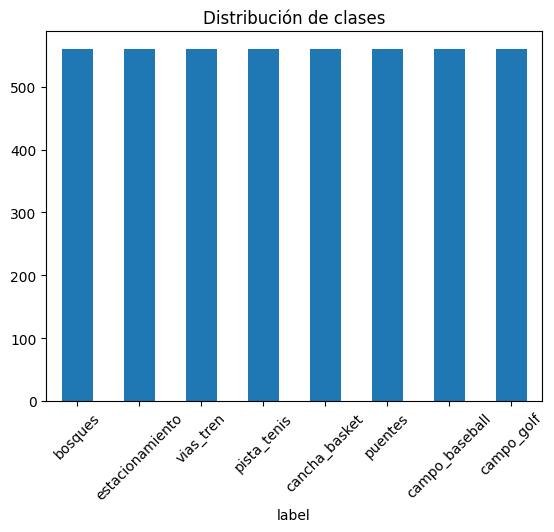

In [5]:
print(train_df["label"].value_counts())
train_df["label"].value_counts().plot(kind="bar", rot=45, title="Distribución de clases");

## Label Encoder

In [6]:
le = LabelEncoder()
train_df["label_idx"] = le.fit_transform(train_df["label"])
test_df["label_idx"] = le.transform(test_df["label"])

N_CLASSES = len(le.classes_)
print("Número de clases:", N_CLASSES)
print("Clases: ", le.classes_)

Número de clases: 8
Clases:  ['bosques' 'campo_baseball' 'campo_golf' 'cancha_basket' 'estacionamiento'
 'pista_tenis' 'puentes' 'vias_tren']


## Preprocesamiento

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SHUFFLE_BUF = len(train_df)

In [8]:

from tensorflow.keras.applications.efficientnet import preprocess_input

def load_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img, label

def normalize_for_model(img, label):
    img = preprocess_input(img) # Esto es para EfficientNet que lo espera
    return img, label

# Data augmentation (aplicada SOLO en train)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.15),
], name="data_augmentation")


In [9]:
# CELDA 7 - Crear datasets evitando el bug con strings (separate from_tensor_slices + zip)
'''X_train = train_df["filepath"].values
y_train = train_df["label_idx"].values
X_test  = test_df["filepath"].values
y_test  = test_df["label_idx"].values

ds_train_x = tf.data.Dataset.from_tensor_slices(X_train)
ds_train_y = tf.data.Dataset.from_tensor_slices(y_train)
ds_test_x  = tf.data.Dataset.from_tensor_slices(X_test)
ds_test_y  = tf.data.Dataset.from_tensor_slices(y_test)

train_ds = tf.data.Dataset.zip((ds_train_x, ds_train_y))
test_ds  = tf.data.Dataset.zip((ds_test_x, ds_test_y))'''

X_train = train_df["filepath"].values
y_train = train_df["label_idx"].values

X_test = test_df["filepath"].values
y_test = test_df["label_idx"].values

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Pipeline de train
train_ds = (
    train_ds
    .shuffle(SHUFFLE_BUF)
    .map(load_and_resize, num_parallel_calls=AUTOTUNE)
    .map(lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    #.map(normalize_for_model, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Pipeline de test (sin augment)
test_ds = (
    test_ds
    .map(load_and_resize, num_parallel_calls=AUTOTUNE)
    #.map(normalize_for_model, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


## Modelado

In [10]:
# CELDA 10 - modelo baseline con EfficientNetB0
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224,224,3))
base_model.trainable = False  # CONGELADA

inputs = keras.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(N_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,563 (16.71 MB)

 Trainable params: 329,992 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Entrenamiento

In [11]:
history = model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.8011 - loss: 0.5742 - val_accuracy: 0.9143 - val_loss: 0.2681
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 46s 328ms/step - accuracy: 0.8813 - loss: 0.3335 - val_accuracy: 0.9152 - val_loss: 0.2356
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 46s 330ms/step - accuracy: 0.9020 - loss: 0.2774 - val_accuracy: 0.9286 - val_loss: 0.2121
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 355ms/step - accuracy: 0.9150 - loss: 0.2393 - val_accuracy: 0.9357 - val_loss: 0.1766
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 359ms/step - accuracy: 0.9181 - loss: 0.2261 - val_accuracy: 0.9304 - val_loss: 0.1988


## Métrica

In [12]:
loss, acc = model.evaluate(test_ds)
print("Accuracy test (head):", acc)

35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.9304 - loss: 0.1988
Accuracy test (head): 0.9303571581840515


## Predecir en test

In [13]:
preds_probs = model.predict(test_ds, verbose=0)
preds = np.argmax(preds_probs, axis=1)

# obtener y_true en el mismo orden
y_true = []
for _, lbls in test_ds:
    y_true.extend(lbls.numpy())
y_true = np.array(y_true, dtype=int)

2025-12-06 22:36:41.579495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Matriz de confusión

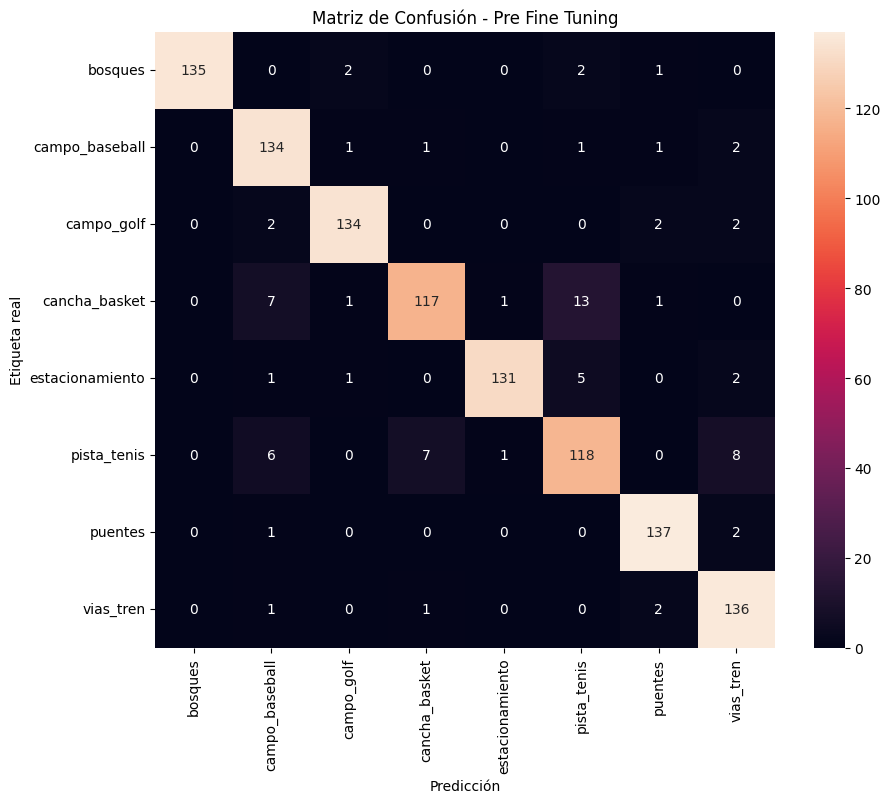

In [14]:
cm = confusion_matrix(y_true, preds)
class_names = le.inverse_transform(np.arange(N_CLASSES))

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión - Pre Fine Tuning")
plt.show()

## Representación predicción visual

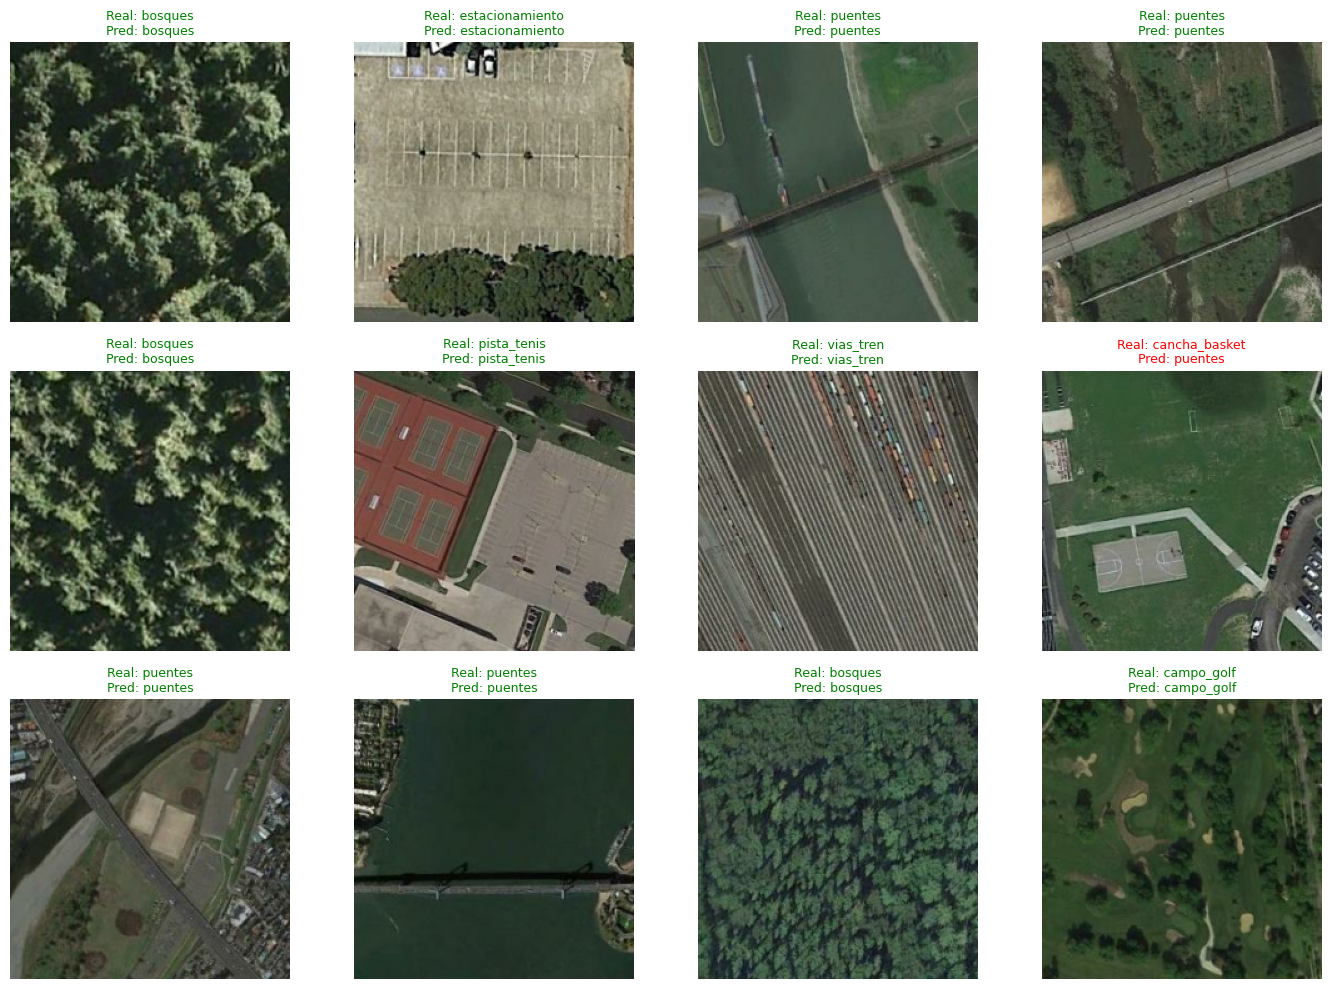

In [20]:
N_show = 12
total_test = len(y_true)
indices = random.sample(range(total_test), N_show)

# reconstruir test_paths en orden (para acceder fácilmente)
test_paths_in_order = list(X_test)  # X_test es el array de rutas en el mismo orden que usamos en el dataset zip

plt.figure(figsize=(14, 10))
for i, idx in enumerate(indices):
    p = test_paths_in_order[idx]
    img = tf.io.read_file(p)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img_np = img.numpy()

    plt.subplot(3,4,i+1)
    plt.imshow(img_np)
    true_lbl_name = le.inverse_transform([y_true[idx]])[0]
    pred_lbl_name = le.inverse_transform([preds[idx]])[0]
    color = "green" if true_lbl_name == pred_lbl_name else "red"
    plt.title(f"Real: {true_lbl_name}\nPred: {pred_lbl_name}", color=color, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Fine Tuning

In [21]:
for layer in base_model.layers[-40:]: # Solo las últimas
    layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history_ft = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 62s 411ms/step - accuracy: 0.8482 - loss: 0.4652 - val_accuracy: 0.9277 - val_loss: 0.2020
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 59s 424ms/step - accuracy: 0.8813 - loss: 0.3618 - val_accuracy: 0.9357 - val_loss: 0.1952
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 59s 424ms/step - accuracy: 0.9085 - loss: 0.2901 - val_accuracy: 0.9446 - val_loss: 0.1783
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 59s 423ms/step - accuracy: 0.9165 - loss: 0.2581 - val_accuracy: 0.9455 - val_loss: 0.1628
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 59s 424ms/step - accuracy: 0.9190 - loss: 0.2379 - val_accuracy: 0.9473 - val_loss: 0.1515
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 60s 430ms/step - accuracy: 0.9263 - loss: 0.2148 - val_accuracy: 0.9509 - val_loss: 0.1419
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 59s 422ms/step - accuracy: 0.9355 - loss: 0.1892 - val_accuracy: 0.9527 - val_loss: 0.1331
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 60s 431ms/step - accuracy: 0.9333 - loss: 0

## Métrica con test

In [22]:
loss, acc = model.evaluate(test_ds)
print("Accuracy test (fine-tuned):", acc)

35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - accuracy: 0.9580 - loss: 0.1183
Accuracy test (fine-tuned): 0.9580357074737549


## Guardamos y cargamos el modelo

In [23]:
model.save("modelo_final.keras")   # formato recomendado
model_importado = tf.keras.models.load_model("modelo_final.keras")

## Matriz de confusión final

2025-12-06 22:47:46.661096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


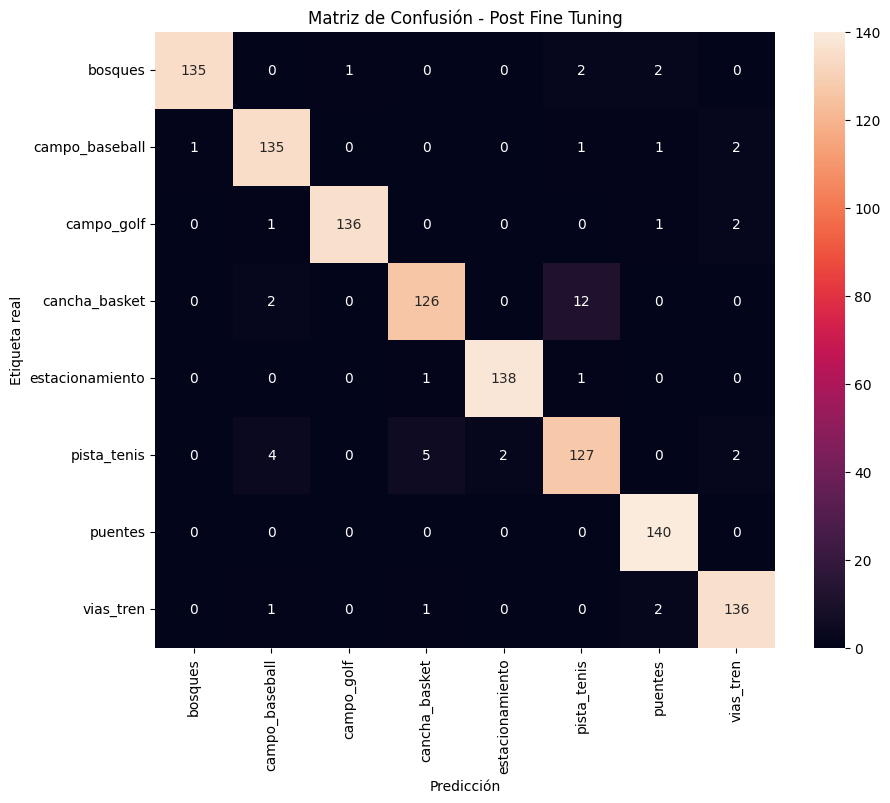

In [24]:
preds_probs_ft = model_importado.predict(test_ds, verbose=0)
preds_ft = np.argmax(preds_probs_ft, axis=1)

# obtener y_true igual que antes
y_true_ft = []
for _, lbls in test_ds:
    y_true_ft.extend(lbls.numpy())
y_true_ft = np.array(y_true_ft, dtype=int)

cm_ft = confusion_matrix(y_true_ft, preds_ft)
class_names = le.inverse_transform(np.arange(N_CLASSES))

plt.figure(figsize=(10,8))
sns.heatmap(cm_ft, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión - Post Fine Tuning")
plt.show();

## Representación final

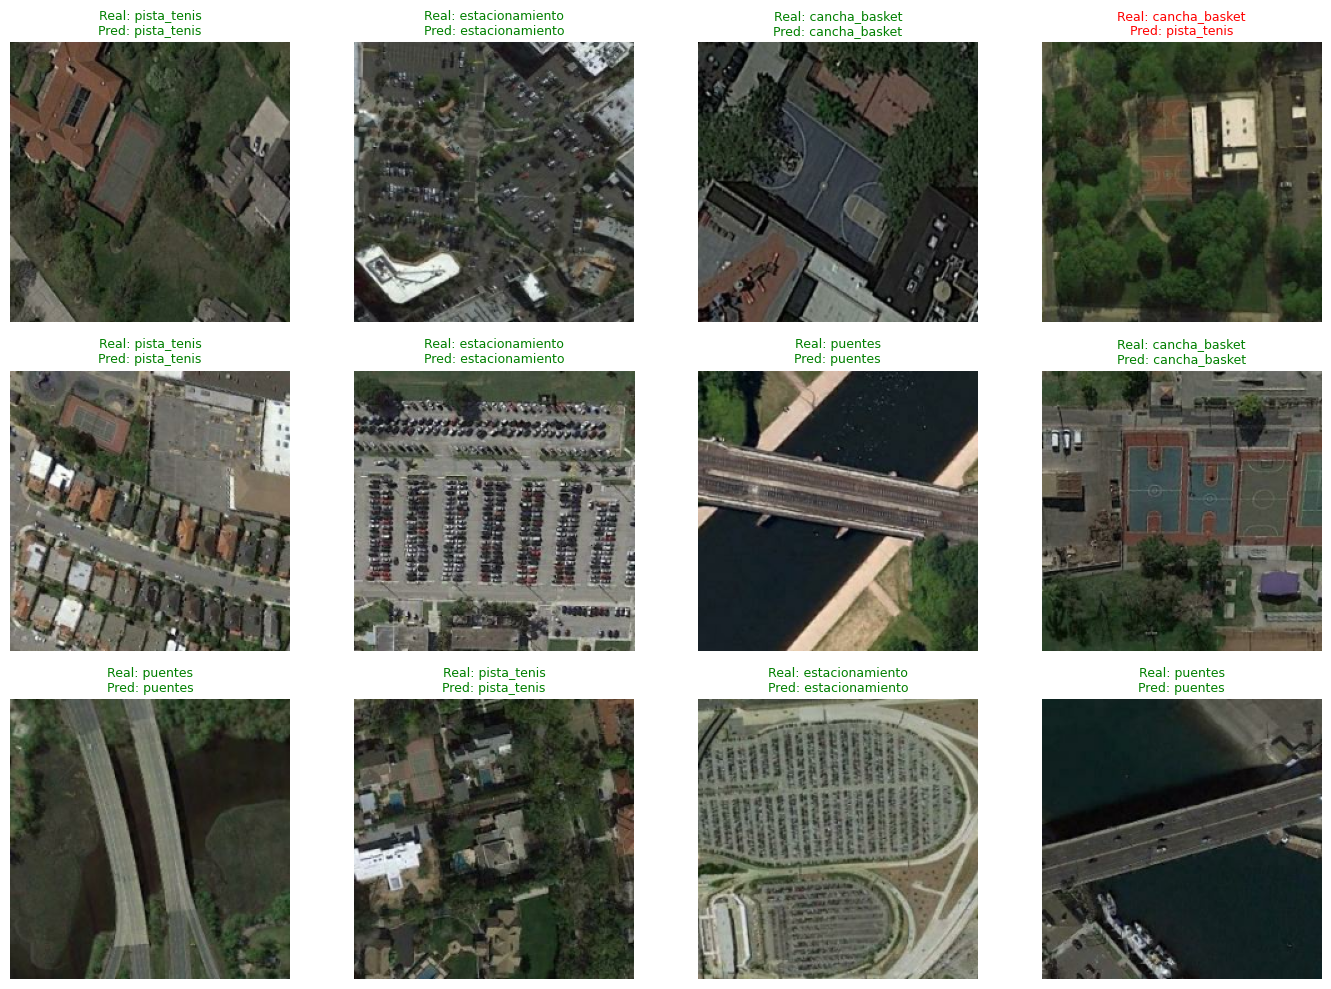

In [25]:
N_show = 12
indices = random.sample(range(len(y_true_ft)), N_show)

plt.figure(figsize=(14, 10))
for i, idx in enumerate(indices):
    p = test_paths_in_order[idx]
    img = tf.io.read_file(p)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img_np = img.numpy()

    plt.subplot(3,4,i+1)
    plt.imshow(img_np)
    true_lbl_name = le.inverse_transform([y_true_ft[idx]])[0]
    pred_lbl_name = le.inverse_transform([preds_ft[idx]])[0]
    color = "green" if true_lbl_name == pred_lbl_name else "red"
    plt.title(f"Real: {true_lbl_name}\nPred: {pred_lbl_name}", color=color, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()